In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer 
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.feature_selection import VarianceThreshold, SelectFromModel
from sklearn.experimental import enable_halving_search_cv 
from sklearn.model_selection import HalvingGridSearchCV

# Import Data
* import data
* categorize variables in categoric, ordinal and numeric
* prepare data for modelling by splitting into train and test-sets

In [2]:
housing = pd.read_csv('data/housing_prices.csv')

X = housing.drop(['SalePrice'], axis=1)
y = housing['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1337)

# get column names of categoric and numeric features
categoric_features =    ['MSZoning', 'Condition1', 'Heating', 'Street', 'CentralAir', 'Foundation', 'BsmtExposure', 'Alley', 'LotShape', 
                        'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 
                        'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Electrical', 'GarageType', 'GarageFinish', 'PavedDrive', 
                        'MiscFeature', 'SaleType', 'SaleCondition']

ordinal_features =      ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 
                        'KitchenQual', 'GarageQual', 'GarageCond', 'Functional', 'FireplaceQu', 'PoolQC', 'Fence']

numeric_features =      ['LotArea', 'LotFrontage', 'TotalBsmtSF', 'BedroomAbvGr', 'Fireplaces', 'PoolArea', 'GarageCars', 'WoodDeckSF', 'ScreenPorch',
                        'MSSubClass', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 
                        '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'KitchenAbvGr', 
                        'TotRmsAbvGrd', 'GarageYrBlt', 'GarageArea', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'MiscVal', 'MoSold', 'YrSold']

# drop id-columns from train and test data
X_train.drop(['Id'], axis=1, inplace=True)
X_test.drop(['Id'], axis=1, inplace=True)

# adjust ordinal features to be upper case due to irregularities in the data
X_train[ordinal_features] = X_train[ordinal_features].apply(lambda x: x.str.upper())
X_test[ordinal_features] = X_test[ordinal_features].apply(lambda x: x.str.upper())

# prepare df for saving metrics of different models
metrics_df = pd.DataFrame()

# Pipeline
* create a function that creates a pipeline including preprocessing and the chosen model 

In [3]:
'''
Creates a pipeline with a model of choice. 
Takes type of model as input (e.g. DecisionTreeClassifier).
Returns a pipeline and the preprocessor.
'''
def create_pipeline(model):    
    
    numeric_pipe = Pipeline(steps= [
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', MinMaxScaler())
        ])
    
    categoric_pipe = Pipeline(steps= [
        ('transformer', OneHotEncoder(handle_unknown= 'ignore'))
        ])

    # define rating categories for ordinal features
    standard_ratings = [['PO', 'FA', 'TA', 'GD', 'EX']]
    bsmt_ratings = [['NA', 'UNF', 'LWQ', 'REC', 'BLQ', 'ALQ', 'GLQ']]
    functional_ratings = [['Sal', 'Sev', 'Maj2', 'Maj1', 'Mod', 'Min2', 'Min1', 'Typ']]
    fence_ratings = [['NA', 'MnWw', 'GdWo', 'MnPrv', 'GdPrv']]

    preprocessor = ColumnTransformer(
        transformers=[
            ('num_pipe', numeric_pipe, numeric_features),
            ('cat_pipe', categoric_pipe, categoric_features),
            ('ExterQual', OrdinalEncoder(categories=standard_ratings, handle_unknown= 'use_encoded_value', unknown_value= -1, encoded_missing_value= -1), ['ExterQual']),
            ('ExterCond', OrdinalEncoder(categories=standard_ratings, handle_unknown= 'use_encoded_value', unknown_value= -1, encoded_missing_value= -1), ['ExterCond']),
            ('BsmtQual', OrdinalEncoder(categories=standard_ratings, handle_unknown= 'use_encoded_value', unknown_value= -1, encoded_missing_value= -1), ['BsmtQual']),
            ('BsmtCond', OrdinalEncoder(categories=standard_ratings, handle_unknown= 'use_encoded_value', unknown_value= -1, encoded_missing_value= -1), ['BsmtCond']),
            ('BsmtFinType1', OrdinalEncoder(categories=bsmt_ratings, handle_unknown= 'use_encoded_value', unknown_value= -1, encoded_missing_value= -1), ['BsmtFinType1']),
            ('BsmtFinType2', OrdinalEncoder(categories=bsmt_ratings, handle_unknown= 'use_encoded_value', unknown_value= -1, encoded_missing_value= -1), ['BsmtFinType2']),
            ('HeatingQC', OrdinalEncoder(categories=standard_ratings, handle_unknown= 'use_encoded_value', unknown_value= -1, encoded_missing_value= -1), ['HeatingQC']),
            ('KitchenQual', OrdinalEncoder(categories=standard_ratings, handle_unknown= 'use_encoded_value', unknown_value= -1, encoded_missing_value= -1), ['KitchenQual']),
            ('GarageQual', OrdinalEncoder(categories=standard_ratings, handle_unknown= 'use_encoded_value', unknown_value= -1, encoded_missing_value= -1), ['GarageQual']),
            ('GarageCond', OrdinalEncoder(categories=standard_ratings, handle_unknown= 'use_encoded_value', unknown_value= -1, encoded_missing_value= -1), ['GarageCond']),
            ('Functional', OrdinalEncoder(categories=functional_ratings, handle_unknown= 'use_encoded_value', unknown_value= -1, encoded_missing_value= -1), ['Functional']),
            ('FireplaceQu', OrdinalEncoder(categories=standard_ratings, handle_unknown= 'use_encoded_value', unknown_value= -1, encoded_missing_value= -1), ['FireplaceQu']),
            ('PoolQC', OrdinalEncoder(categories=standard_ratings, handle_unknown= 'use_encoded_value', unknown_value= -1, encoded_missing_value= -1), ['PoolQC']),
            ('Fence', OrdinalEncoder(categories=fence_ratings, handle_unknown= 'use_encoded_value', unknown_value= -1, encoded_missing_value= -1), ['Fence'])
        ], verbose= False
    )

    pipe = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('var_threshold', VarianceThreshold()),
        ('feature_sel', SelectFromModel(model())),
        ('classifier', model())
        ])
    return pipe, preprocessor

# Pipeline with PCA

In [4]:
'''
Creates a pipeline with a model of choice. 
Takes type of model as input (e.g. DecisionTreeClassifier).
Returns a pipeline and the preprocessor.
'''
def create_pca_pipeline(model):    
    
    numeric_pipe = Pipeline(steps= [
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', MinMaxScaler())
        ])
    
    categoric_pipe = Pipeline(steps= [
        ('transformer', OneHotEncoder(handle_unknown= 'ignore'))
        ])

    # define rating categories for ordinal features
    standard_ratings = [['PO', 'FA', 'TA', 'GD', 'EX']]
    bsmt_ratings = [['NA', 'UNF', 'LWQ', 'REC', 'BLQ', 'ALQ', 'GLQ']]
    functional_ratings = [['Sal', 'Sev', 'Maj2', 'Maj1', 'Mod', 'Min2', 'Min1', 'Typ']]
    fence_ratings = [['NA', 'MnWw', 'GdWo', 'MnPrv', 'GdPrv']]

    preprocessor = ColumnTransformer(
        transformers=[
            ('num_pipe', numeric_pipe, numeric_features),
            ('cat_pipe', categoric_pipe, categoric_features),
            ('ExterQual', OrdinalEncoder(categories=standard_ratings, handle_unknown= 'use_encoded_value', unknown_value= -1, encoded_missing_value= -1), ['ExterQual']),
            ('ExterCond', OrdinalEncoder(categories=standard_ratings, handle_unknown= 'use_encoded_value', unknown_value= -1, encoded_missing_value= -1), ['ExterCond']),
            ('BsmtQual', OrdinalEncoder(categories=standard_ratings, handle_unknown= 'use_encoded_value', unknown_value= -1, encoded_missing_value= -1), ['BsmtQual']),
            ('BsmtCond', OrdinalEncoder(categories=standard_ratings, handle_unknown= 'use_encoded_value', unknown_value= -1, encoded_missing_value= -1), ['BsmtCond']),
            ('BsmtFinType1', OrdinalEncoder(categories=bsmt_ratings, handle_unknown= 'use_encoded_value', unknown_value= -1, encoded_missing_value= -1), ['BsmtFinType1']),
            ('BsmtFinType2', OrdinalEncoder(categories=bsmt_ratings, handle_unknown= 'use_encoded_value', unknown_value= -1, encoded_missing_value= -1), ['BsmtFinType2']),
            ('HeatingQC', OrdinalEncoder(categories=standard_ratings, handle_unknown= 'use_encoded_value', unknown_value= -1, encoded_missing_value= -1), ['HeatingQC']),
            ('KitchenQual', OrdinalEncoder(categories=standard_ratings, handle_unknown= 'use_encoded_value', unknown_value= -1, encoded_missing_value= -1), ['KitchenQual']),
            ('GarageQual', OrdinalEncoder(categories=standard_ratings, handle_unknown= 'use_encoded_value', unknown_value= -1, encoded_missing_value= -1), ['GarageQual']),
            ('GarageCond', OrdinalEncoder(categories=standard_ratings, handle_unknown= 'use_encoded_value', unknown_value= -1, encoded_missing_value= -1), ['GarageCond']),
            ('Functional', OrdinalEncoder(categories=functional_ratings, handle_unknown= 'use_encoded_value', unknown_value= -1, encoded_missing_value= -1), ['Functional']),
            ('FireplaceQu', OrdinalEncoder(categories=standard_ratings, handle_unknown= 'use_encoded_value', unknown_value= -1, encoded_missing_value= -1), ['FireplaceQu']),
            ('PoolQC', OrdinalEncoder(categories=standard_ratings, handle_unknown= 'use_encoded_value', unknown_value= -1, encoded_missing_value= -1), ['PoolQC']),
            ('Fence', OrdinalEncoder(categories=fence_ratings, handle_unknown= 'use_encoded_value', unknown_value= -1, encoded_missing_value= -1), ['Fence'])
        ], verbose= False
    )

    # remove feature-selector when using KNN
    if model == KNeighborsClassifier:
        pipe = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('var_threshold', VarianceThreshold()),
            ('PCA', PCA(n_components=0.95)),
            ('classifier', model())
            ])
    else: 
        pipe = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('var_threshold', VarianceThreshold()),
            ('feature_sel', SelectFromModel(model())),
            ('PCA', PCA(n_components=0.95)),
            ('classifier', model())
            ])
    return pipe, preprocessor

# Plotting Function

In [5]:
# function to plot y_pred vs y_true for a given model
def plot_predictions(y_true, y_pred, title): 
    max_preds = min([max(y_pred.tolist()), max(y_true.tolist())])
    min_preds = min([min(y_pred.tolist()), min(y_true.tolist())])
    # plot
    plt.figure(figsize=(8,8))
    sns.scatterplot(x=y_pred, y=y_true)
    sns.lineplot(x=[min_preds,max_preds], y=[min_preds, max_preds], color='red')
    plt.ylabel('Reference')
    plt.xlabel('Predictions')
    plt.title(title)
    plt.show()

# Gridsearch Function

In [6]:
def halving_gridsearch(pipeline, parameter_grid, X, y, cv=3):
    # create a halving gridsearch
    halving_gridsearch = HalvingGridSearchCV(pipeline, parameter_grid, cv=cv)
    # fit the model
    halving_gridsearch.fit(X, y)
    # return gridsearch object
    return halving_gridsearch

# Linear Regression
* conduct linear regression analysis on train-set

## Fit and Predict

In [7]:
# create pipelines
linear_regression_pipe, preprocessor = create_pipeline(LinearRegression)

# fit
linear_regression_pipe.fit(X_train, y_train)

# predict
y_pred_train = linear_regression_pipe.predict(X_train)
y_pred_test = linear_regression_pipe.predict(X_test)

## Evaluate

In [8]:
linear_regression_train = pd.DataFrame(
    {'true_value': y_train,
     'predicted_value': y_pred_train}
)

linear_regression_test = pd.DataFrame(
    {'true_value': y_test,
     'predicted_value': y_pred_test}
)

print('Train Data\n', linear_regression_train.head())
print('Test Data\n', linear_regression_test.head())

Train Data
       true_value  predicted_value
1220      115000         106688.0
1285      132500         129280.0
573       170000         174656.0
793       225000         265088.0
104       169500         154752.0
Test Data
       true_value  predicted_value
114       259500         225728.0
678       372500         300416.0
71        129500         107520.0
998        91000          91328.0
1170      171000         144128.0


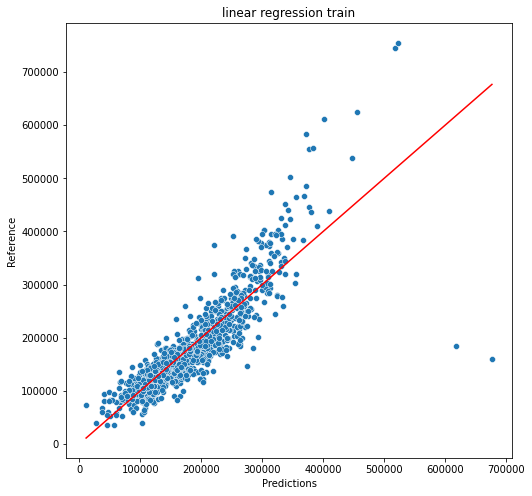

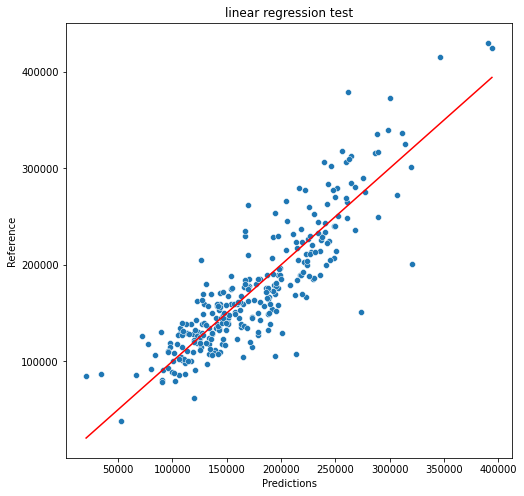

In [9]:
# plot predictions vs true values
plot_predictions(linear_regression_train['true_value'], linear_regression_train['predicted_value'], 'linear regression train')
plot_predictions(linear_regression_test['true_value'], linear_regression_test['predicted_value'], 'linear regression test')

In [10]:
# add train metrics to metrics_df
metrics_df.loc['linear_regression_train', 'r2']     = r2_score(linear_regression_train['true_value'], linear_regression_train['predicted_value'])
metrics_df.loc['linear_regression_train', 'RMSE']   = np.sqrt(mean_squared_error(linear_regression_train.true_value, linear_regression_train.predicted_value))
metrics_df.loc['linear_regression_train', 'MSE']    = mean_squared_error(linear_regression_train.true_value, linear_regression_train.predicted_value)
metrics_df.loc['linear_regression_train', 'MAE']    = mean_absolute_error(linear_regression_train.true_value, linear_regression_train.predicted_value)

# add test metrics to metrics_df
metrics_df.loc['linear_regression_test', 'r2']     = r2_score(linear_regression_test['true_value'], linear_regression_test['predicted_value'])
metrics_df.loc['linear_regression_test', 'RMSE']   = np.sqrt(mean_squared_error(linear_regression_test.true_value, linear_regression_test.predicted_value))
metrics_df.loc['linear_regression_test', 'MSE']    = mean_squared_error(linear_regression_test.true_value, linear_regression_test.predicted_value)
metrics_df.loc['linear_regression_test', 'MAE']    = mean_absolute_error(linear_regression_test.true_value, linear_regression_test.predicted_value)

## With PCA

In [11]:
# create pipelines
linear_regression_pca_pipe, preprocessor = create_pca_pipeline(LinearRegression)

# fit
linear_regression_pca_pipe.fit(X_train, y_train)

# predict
y_pred_train = linear_regression_pca_pipe.predict(X_train)
y_pred_test = linear_regression_pca_pipe.predict(X_test)

### Evaluate

In [12]:
linear_regression_pca_train = pd.DataFrame(
    {'true_value': y_train,
     'predicted_value': y_pred_train}
)

linear_regression_pca_test = pd.DataFrame(
    {'true_value': y_test,
     'predicted_value': y_pred_test}
)

print('Train Data\n', linear_regression_pca_train.head())
print('Test Data\n', linear_regression_pca_test.head())

Train Data
       true_value  predicted_value
1220      115000    119645.346983
1285      132500    134508.419033
573       170000    172693.866143
793       225000    325351.439500
104       169500    167354.253514
Test Data
       true_value  predicted_value
114       259500    156234.677711
678       372500    317198.374151
71        129500    104961.159653
998        91000     69320.648227
1170      171000    184024.768758


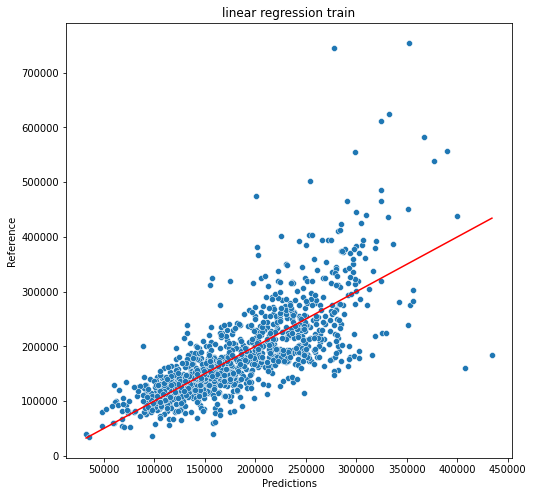

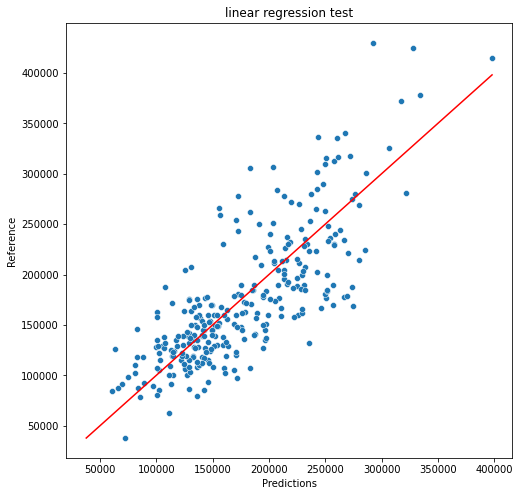

In [13]:
# plot predictions vs true values
plot_predictions(linear_regression_pca_train['true_value'], linear_regression_pca_train['predicted_value'], 'linear regression train')
plot_predictions(linear_regression_pca_test['true_value'], linear_regression_pca_test['predicted_value'], 'linear regression test')

In [14]:
# add train metrics to metrics_df
metrics_df.loc['linear_regression_pca_train', 'r2']     = r2_score(linear_regression_pca_train['true_value'], linear_regression_pca_train['predicted_value'])
metrics_df.loc['linear_regression_pca_train', 'RMSE']   = np.sqrt(mean_squared_error(linear_regression_pca_train.true_value, linear_regression_pca_train.predicted_value))
metrics_df.loc['linear_regression_pca_train', 'MSE']    = mean_squared_error(linear_regression_pca_train.true_value, linear_regression_pca_train.predicted_value)
metrics_df.loc['linear_regression_pca_train', 'MAE']    = mean_absolute_error(linear_regression_pca_train.true_value, linear_regression_pca_train.predicted_value)

# add test metrics to metrics_df
metrics_df.loc['linear_regression_pca_test', 'r2']     = r2_score(linear_regression_pca_test['true_value'], linear_regression_pca_test['predicted_value'])
metrics_df.loc['linear_regression_pca_test', 'RMSE']   = np.sqrt(mean_squared_error(linear_regression_pca_test.true_value, linear_regression_pca_test.predicted_value))
metrics_df.loc['linear_regression_pca_test', 'MSE']    = mean_squared_error(linear_regression_pca_test.true_value, linear_regression_pca_test.predicted_value)
metrics_df.loc['linear_regression_pca_test', 'MAE']    = mean_absolute_error(linear_regression_pca_test.true_value, linear_regression_pca_test.predicted_value)

# Random Forest Regression

## Fit and Predict

In [15]:
random_forest_pipe, preprocessor = create_pipeline(RandomForestRegressor)

# fit pipeline
random_forest_pipe.fit(X_train, y_train)
y_pred_train = random_forest_pipe.predict(X_train)
y_pred_test = random_forest_pipe.predict(X_test)

## Evaluate

In [16]:
random_forest_train = pd.DataFrame(
    {'true_value': y_train,
     'predicted_value': y_pred_train}
)

random_forest_test = pd.DataFrame(
    {'true_value': y_test,
     'predicted_value': y_pred_test}
)

print('Train Data\n', random_forest_train.head())
print('Test Data\n', random_forest_test.head())

Train Data
       true_value  predicted_value
1220      115000        116145.00
1285      132500        128833.64
573       170000        170869.10
793       225000        228468.44
104       169500        165133.34
Test Data
       true_value  predicted_value
114       259500        186133.20
678       372500        307139.91
71        129500        118207.00
998        91000        108547.00
1170      171000        147625.00


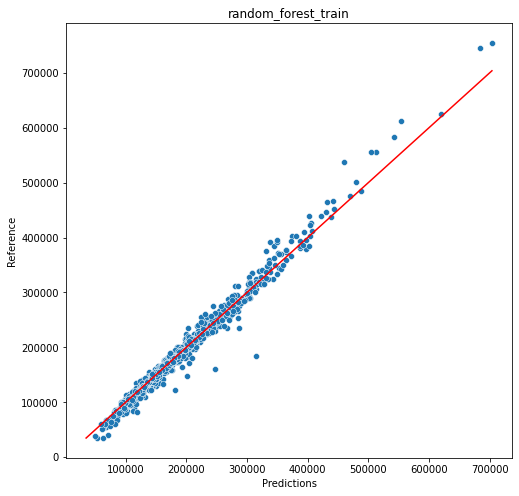

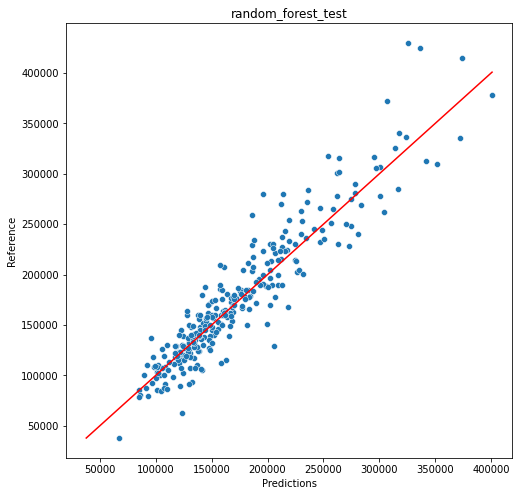

In [17]:
# plot predictions vs true values
plot_predictions(random_forest_train['true_value'], random_forest_train['predicted_value'], 'random_forest_train')
plot_predictions(random_forest_test['true_value'], random_forest_test['predicted_value'], 'random_forest_test')

In [18]:
# add train metrics to metrics_df
metrics_df.loc['random_forest_train', 'r2']     = r2_score(random_forest_train['true_value'], random_forest_train['predicted_value'])
metrics_df.loc['random_forest_train', 'RMSE']   = np.sqrt(mean_squared_error(random_forest_train.true_value, random_forest_train.predicted_value))
metrics_df.loc['random_forest_train', 'MSE']    = mean_squared_error(random_forest_train.true_value, random_forest_train.predicted_value)
metrics_df.loc['random_forest_train', 'MAE']    = mean_absolute_error(random_forest_train.true_value, random_forest_train.predicted_value)

# add test metrics to metrics_df
metrics_df.loc['random_forest_test', 'r2']     = r2_score(random_forest_test['true_value'], random_forest_test['predicted_value'])
metrics_df.loc['random_forest_test', 'RMSE']   = np.sqrt(mean_squared_error(random_forest_test.true_value, random_forest_test.predicted_value))
metrics_df.loc['random_forest_test', 'MSE']    = mean_squared_error(random_forest_test.true_value, random_forest_test.predicted_value)
metrics_df.loc['random_forest_test', 'MAE']    = mean_absolute_error(random_forest_test.true_value, random_forest_test.predicted_value)

## Tuning

In [49]:
parameter_grid = {
    'preprocessor__num_pipe__imputer__strategy': ['mean', 'median'],
    'classifier__n_estimators': [10, 50, 100, 200],
    'classifier__max_depth': [None, 2, 4, 6, 8],
    'classifier__min_samples_split': [2, 3, 4, 5, 6],
    'classifier__min_samples_leaf': [1, 2, 3, 4, 5],
}

gridsearch_result = halving_gridsearch(random_forest_pipe, parameter_grid, X_train, y_train)

c:\Users\tobia\miniconda3\envs\home\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tobia\miniconda3\envs\home\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tobia\miniconda3\envs\home\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tobia\miniconda3\envs\home\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\tobia\miniconda3\envs\home\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not w

KeyboardInterrupt: 

In [ ]:
# save gridsearch predictions
y_pred_train = gridsearch_result.predict(X_train)
y_pred_test = gridsearch_result.predict(X_test)

random_forest_gridsearch_train = pd.DataFrame(
    {'true_value': y_train,
     'predicted_value': y_pred_train}
)

random_forest_gridsearch_test = pd.DataFrame(
    {'true_value': y_test,
     'predicted_value': y_pred_test}
)

print('Train Data\n', random_forest_gridsearch_train.head())
print('Test Data\n', random_forest_gridsearch_test.head())

Train Data
       true_value  predicted_value
1220      115000    117144.825159
1285      132500    130579.788175
573       170000    169690.558220
793       225000    229428.830238
104       169500    166731.727163
Test Data
       true_value  predicted_value
114       259500    190273.338889
678       372500    304971.762526
71        129500    121575.099429
998        91000     98423.246952
1170      171000    145703.717044


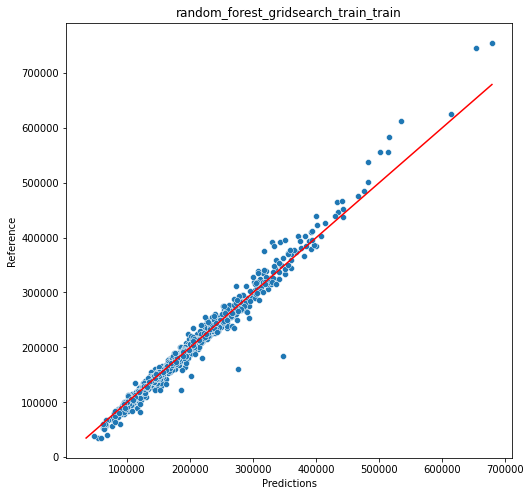

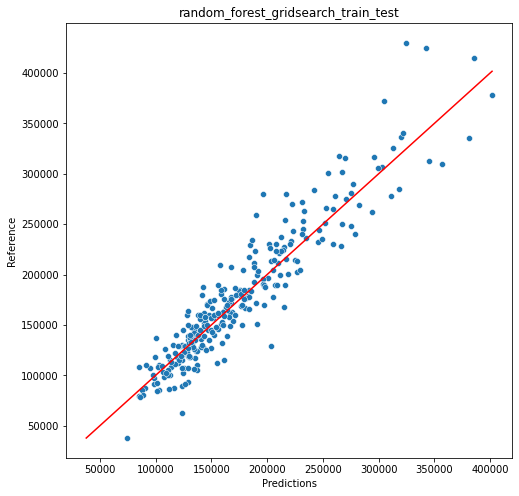

In [ ]:
# plot predictions vs true values
plot_predictions(random_forest_gridsearch_train['true_value'], random_forest_gridsearch_train['predicted_value'], 'random_forest_gridsearch_train_train')
plot_predictions(random_forest_gridsearch_test['true_value'], random_forest_gridsearch_test['predicted_value'], 'random_forest_gridsearch_train_test')

In [ ]:
# add train metrics to metrics_df
metrics_df.loc['random_forest_gridsearch_train', 'r2']     = r2_score(random_forest_gridsearch_train['true_value'], random_forest_gridsearch_train['predicted_value'])
metrics_df.loc['random_forest_gridsearch_train', 'RMSE']   = np.sqrt(mean_squared_error(random_forest_gridsearch_train.true_value, random_forest_gridsearch_train.predicted_value))
metrics_df.loc['random_forest_gridsearch_train', 'MSE']    = mean_squared_error(random_forest_gridsearch_train.true_value, random_forest_gridsearch_train.predicted_value)
metrics_df.loc['random_forest_gridsearch_train', 'MAE']    = mean_absolute_error(random_forest_gridsearch_train.true_value, random_forest_gridsearch_train.predicted_value)

# add test metrics to metrics_df
metrics_df.loc['random_forest_gridsearch_test', 'r2']     = r2_score(random_forest_gridsearch_test['true_value'], random_forest_gridsearch_test['predicted_value'])
metrics_df.loc['random_forest_gridsearch_test', 'RMSE']   = np.sqrt(mean_squared_error(random_forest_gridsearch_test.true_value, random_forest_gridsearch_test.predicted_value))
metrics_df.loc['random_forest_gridsearch_test', 'MSE']    = mean_squared_error(random_forest_gridsearch_test.true_value, random_forest_gridsearch_test.predicted_value)
metrics_df.loc['random_forest_gridsearch_test', 'MAE']    = mean_absolute_error(random_forest_gridsearch_test.true_value, random_forest_gridsearch_test.predicted_value)

In [ ]:
metrics_df

,r2,RMSE,MSE,MAE
linear_regression_train,0.762238,40159.438060,1.612780e+09,24733.277397
linear_regression_test,0.770334,31609.109741,9.991358e+08,23560.205479
random_forest_train,0.981657,11154.617188,1.244255e+08,6769.066191
random_forest_test,0.875282,23293.135665,5.425702e+08,16578.994098
linear_regression_pca_train,0.573414,53792.192724,2.893600e+09,35791.142144
linear_regression_pca_test,0.611669,41102.225715,1.689393e+09,31471.826716
random_forest_gridsearch_train,0.976943,12506.104997,1.564027e+08,7083.160341
random_forest_gridsearch_test,0.880481,22802.460613,5.199522e+08,16296.975644


## Results of previous run
<pre>
	                            r2	            RMSE	        MSE	        MAE
linear_regression_train	            0.762238	    40159.438060	1.612780e+09	24733.277397
linear_regression_test	            0.770334	    31609.109741	9.991358e+08	23560.205479
random_forest_train	            0.981657	    11154.617188	1.244255e+08	6769.066191
random_forest_test	            0.875282	    23293.135665	5.425702e+08	16578.994098
linear_regression_pca_train	    0.573414	    53792.192724	2.893600e+09	35791.142144
linear_regression_pca_test	    0.611669	    41102.225715	1.689393e+09	31471.826716
random_forest_gridsearch_train	    0.976943	    12506.104997	1.564027e+08	7083.160341
random_forest_gridsearch_test	    0.880481	    22802.460613	5.199522e+08	16296.975644
<pre>

# KNN

## Fit and Predict

Note: Feature Selector needs to be turned off in the pipeline to work with KNN.

In [19]:
knn_pipe, preprocessor = create_pca_pipeline(KNeighborsClassifier)

# fit pipeline
knn_pipe.fit(X_train, y_train)
y_pred_train = knn_pipe.predict(X_train)
y_pred_test = knn_pipe.predict(X_test)

## Evaluate

In [20]:
knn_train = pd.DataFrame(
    {'true_value': y_train,
     'predicted_value': y_pred_train}
)

knn_test = pd.DataFrame(
    {'true_value': y_test,
     'predicted_value': y_pred_test}
)

print('Train Data\n', knn_train.head())
print('Test Data\n', knn_test.head())

Train Data
       true_value  predicted_value
1220      115000           115000
1285      132500           132500
573       170000           170000
793       225000           176485
104       169500           117000
Test Data
       true_value  predicted_value
114       259500           119000
678       372500           179540
71        129500           110000
998        91000           102000
1170      171000           123000


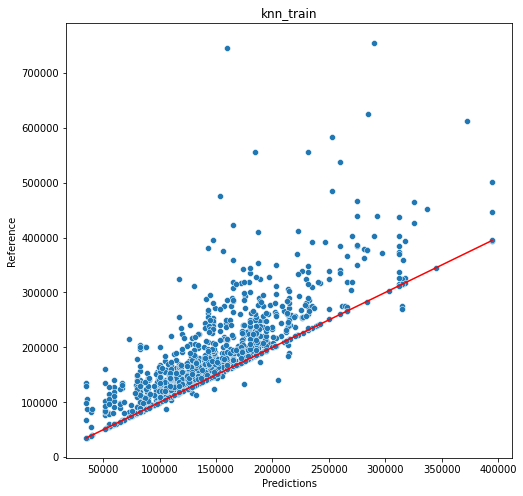

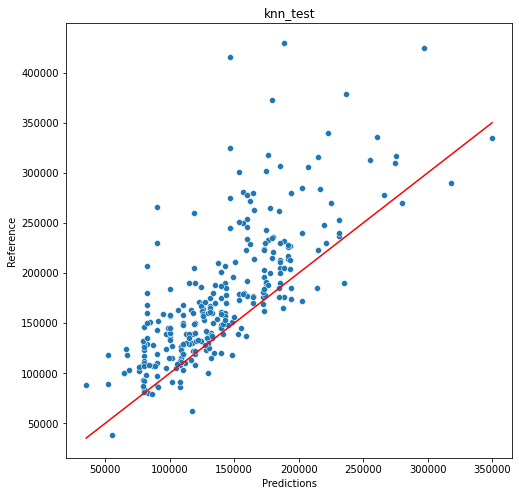

In [21]:
# plot predictions vs true values
plot_predictions(knn_train['true_value'], knn_train['predicted_value'], 'knn_train')
plot_predictions(knn_test['true_value'], knn_test['predicted_value'], 'knn_test')

In [22]:
# add train metrics to metrics_df
metrics_df.loc['knn_train', 'r2']     = r2_score(knn_train['true_value'], knn_train['predicted_value'])
metrics_df.loc['knn_train', 'RMSE']   = np.sqrt(mean_squared_error(knn_train.true_value, knn_train.predicted_value))
metrics_df.loc['knn_train', 'MSE']    = mean_squared_error(knn_train.true_value, knn_train.predicted_value)
metrics_df.loc['knn_train', 'MAE']    = mean_absolute_error(knn_train.true_value, knn_train.predicted_value)

# add test metrics to metrics_df
metrics_df.loc['knn_test', 'r2']     = r2_score(knn_test['true_value'], knn_test['predicted_value'])
metrics_df.loc['knn_test', 'RMSE']   = np.sqrt(mean_squared_error(knn_test.true_value, knn_test.predicted_value))
metrics_df.loc['knn_test', 'MSE']    = mean_squared_error(knn_test.true_value, knn_test.predicted_value)
metrics_df.loc['knn_test', 'MAE']    = mean_absolute_error(knn_test.true_value, knn_test.predicted_value)